In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from zipfile import ZipFile

file_name = "/content/Cricketer_Photos.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

In [0]:
from zipfile import ZipFile

file_name = "/content/Cricket_test.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [0]:
from zipfile import ZipFile

file_name = "/content/drive/My Drive/face_recognition/photos.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


#1111

In [0]:
import numpy as np
import os.path
import cv2
import dlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from Align import AlignDlib
#import align
#import openface
from tqdm import tqdm
from model import create_model

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from joblib import dump, load
from sklearn.metrics import f1_score, accuracy_score

Using TensorFlow backend.


In [0]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('photos')

In [0]:
len(metadata)

113

In [0]:
names = np.array([m.name for m in metadata])

In [0]:
names

In [0]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [0]:
#No need to run this cell

import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [0]:
alignment = AlignDlib('/content/drive/My Drive/face_recognition/models/landmarks.dat')

In [0]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img),landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [0]:
img = cv2.imread("W_1.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

In [0]:
face = alignment.getLargestFaceBoundingBox(img)

In [0]:
x = face.left()
y = face.top()
w = face.width()
h = face.height()

In [0]:
img1 = cv2.rectangle(img ,(x,y),(x+w,y+h),(255, 0, 0), 2)
crop_img = img1[y:y+h, x:x+w]

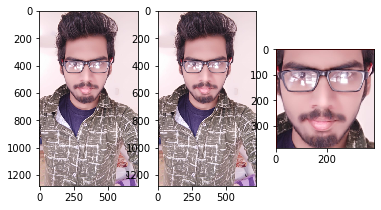

In [0]:
plt.subplot(131)
plt.imshow(img)
plt.subplot(132)
plt.imshow(img1)
plt.subplot(133)
plt.imshow(crop_img)

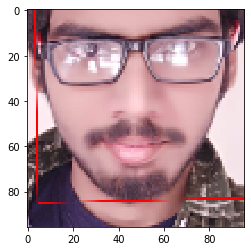

In [0]:
face_aligned = alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
plt.imshow(face_aligned)

In [0]:
model = create_model()
model.load_weights('/content/drive/My Drive/open_face.h5')

In [0]:
count=0

In [0]:
embedded = np.zeros((metadata.shape[0], 128))

for i, m in tqdm(enumerate(metadata)):
    img = load_image(m.image_path())
    try:
      img = align_image(img)
      # scale RGB values to interval [0,1]
      img = (img / 255.).astype(np.float32)
      # obtain embedding vector for image
      embedded[i] = model.predict(np.expand_dims(img, axis=0))[0]
    except:
      count+=1

113it [02:54,  1.54s/it]


In [0]:
metadata

In [0]:
metadata[0].image_path()

'photos/Gerhard_Schroeder/Gerhard_Schroeder_0009.jpg'

In [0]:
import pandas as pd 
df = pd.DataFrame(embedded)

In [0]:
df["names"]=names
print(df.shape)
df.head()

(113, 129)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,names
0,0.035966,0.131935,-0.059532,-0.130664,-0.003347,-0.056471,0.019027,-0.183440,-0.118823,0.069055,0.026678,-0.056534,0.002959,0.112872,0.079517,0.062036,-0.009740,-0.040522,0.152075,-0.061935,-0.081882,0.197105,-0.058348,-0.112408,-0.058143,0.170052,0.071998,0.018735,0.163326,0.184416,-0.185867,0.040042,0.046947,-0.062335,0.124207,-0.001533,0.130487,0.020860,0.199807,0.020338,...,0.137625,0.079759,0.011530,-0.053414,0.108708,-0.008917,0.014506,0.014522,0.046488,0.204002,-0.021948,0.029990,0.059853,0.013397,-0.040417,-0.114282,0.020494,0.039996,0.036891,0.015231,0.018880,0.150778,-0.094683,-0.022475,-0.043009,-0.024391,0.054603,-0.041934,-0.035137,-0.056900,-0.066215,0.054030,-0.081874,0.089238,-0.007503,-0.037187,0.065456,0.017847,-0.061920,Gerhard_Schroeder
1,-0.001402,0.092973,0.026111,-0.175862,-0.021310,-0.031037,-0.003032,-0.103679,-0.106579,0.142953,0.076798,-0.053605,0.031497,0.141056,0.178446,0.028804,-0.053585,-0.078095,0.097594,-0.064631,-0.154218,0.265677,-0.083067,-0.038033,-0.091992,0.189944,0.109103,0.094593,0.152834,0.087634,-0.158558,0.003138,-0.011230,-0.010317,0.031682,0.091958,0.107674,-0.021159,0.160353,0.180888,...,0.117518,0.054533,0.030573,0.012741,0.116678,-0.074455,-0.025712,-0.025194,-0.068613,0.213787,-0.028419,-0.008687,0.059411,-0.003943,-0.042850,-0.065269,0.023090,-0.052852,-0.026773,0.010404,0.031449,0.141426,-0.019412,-0.011316,-0.001610,-0.062187,0.038713,0.010853,-0.032934,-0.099408,-0.075015,0.109154,-0.097504,0.073238,0.033517,-0.082099,0.065788,-0.043029,0.004274,Gerhard_Schroeder
2,0.036393,0.182857,0.064373,-0.135786,0.039373,0.028799,-0.075653,-0.061785,-0.098453,0.034601,0.011127,-0.144591,-0.041795,0.073896,0.119233,0.046914,0.004026,-0.049523,0.022869,-0.029702,-0.072371,0.220178,0.016858,-0.101242,-0.029597,-0.056766,0.052376,0.173074,0.152836,0.021670,-0.122940,-0.102730,0.006707,-0.023800,0.069196,0.068224,0.069818,-0.119113,0.061259,0.060479,...,0.216569,0.099837,0.034940,-0.068982,0.168170,-0.047924,-0.035731,-0.017548,0.023470,0.063666,-0.057936,0.102982,0.063118,-0.021328,-0.114192,-0.061699,0.067166,0.020894,0.007204,0.050128,0.049790,0.148304,-0.053716,0.056794,0.047830,-0.058167,0.034830,-0.080720,0.079843,-0.068459,-0.005256,0.000414,-0.079802,0.063574,0.008656,0.010856,0.047083,0.067292,-0.067288,Gerhard_Schroeder
3,0.060502,0.089764,0.004161,-0.119980,-0.032268,0.034176,-0.016932,-0.129614,-0.109945,0.088060,0.062793,-0.061091,-0.009541,0.027556,0.112385,0.058881,-0.043225,0.033418,0.071872,-0.076399,-0.105727,0.233067,-0.104968,-0.069776,-0.099706,0.186514,0.041579,0.025266,0.131805,0.074780,-0.140761,0.133107,-0.039178,0.007528,0.111087,0.050277,0.100808,-0.065294,0.216166,0.028495,...,0.203844,0.166536,0.035172,-0.074697,0.151093,-0.023307,0.107103,-0.015638,-0.014862,0.152005,-0.008981,0.057338,0.015424,-0.049119,-0.059132,-0.018247,0.055082,0.028130,-0.034651,-0.019174,0.051899,0.131016,-0.007607,0.013334,-0.070000,0.025232,-0.030019,-0.026228,-0.056547,0.013879,-0.118240,0.127000,-0.129822,0.178722,-0.000699,-0.012678,0.026310,0.049690,-0.091761,Gerhard_Schroeder
4,0.056340,-0.026690,0.014247,-0.166951,0.028951,-0.033096,0.055524,-0.001751,-0.107791,0.088974,0.085374,-0.044992,0.042586,0.195563,0.177266,0.076378,0.021084,-0.031460,0.086577,-0.103868,-0.040724,0.251196,-0.102619,-0.164592,-0.081707,0.201748,0.069697,0.046648,0.072493,0.070932,-0.171279,0.033644,0.009011,-0.008104,0.068544,0.089655,0.110005,-0.021305,0.152941,0.077171,...,0.101541,0.048959,-0.006667,-0.114028,0.054597,-0.041319,0.056458,0.005537,-0.082280,0.128740,0.064212,-0.046418,0.041456,0.025631,-0.096639,-0.059134,0.001738,-0.061712,-0.031371,-0.034257,-0.039476,0.051194,-0.121847,-0.056586,-0.044372,0.064404,0.015660,0.012427,-0.098

In [0]:
# To find the euclidean distance between the two embeddings
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [0]:
targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

In [0]:
y=targets

In [0]:
# Train Test split

train_idx = np.arange(metadata.shape[0]) % 5 != 0
test_idx = np.arange(metadata.shape[0]) % 5 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

In [0]:
len(X_train)

90

##SVM

In [0]:
from sklearn.linear_model import SGDClassifier

In [0]:
C = [ 10**-4,10**-3,10**-2,10**-1,10**0,10**1,10**2,10**3,10**4,10**5 ]

In [0]:
accuracy=[]
for c in C:
  svc = LinearSVC(C=c)
  svc.fit(X_train, y_train)
  acc_svc = accuracy_score(y_test, svc.predict(X_test))
  accuracy.append(acc_svc)
  print(c,f'SVM accuracy = {acc_svc}')

0.0001 SVM accuracy = 0.5652173913043478
0.001 SVM accuracy = 0.5652173913043478
0.01 SVM accuracy = 0.6521739130434783
0.1 SVM accuracy = 0.8260869565217391
1 SVM accuracy = 0.9130434782608695
10 SVM accuracy = 1.0
100 SVM accuracy = 0.9565217391304348
1000 SVM accuracy = 0.9565217391304348
10000 SVM accuracy = 0.9565217391304348
100000 SVM accuracy = 0.9565217391304348


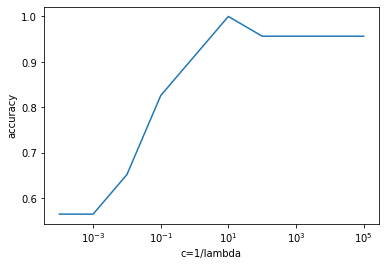

In [0]:
# plot sparsity vs cC_log = np.log(C)
plt.plot(C,accuracy)
plt.xlabel('c=1/lambda')
plt.ylabel('accuracy')
plt.xscale('log')
plt.show()

In [0]:
svc = SVC(C=1,probability=True)
svc.fit(X_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [0]:
acc_svc = accuracy_score(y_test, svc.predict(X_test))
accuracy.append(acc_svc)
print(f'SVM accuracy = {acc_svc}')

SVM accuracy = 0.8695652173913043


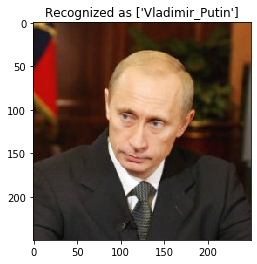

In [0]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 11

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embedded[test_idx][example_idx]])

plt.imshow(example_image)
plt.title(f'Recognized as {example_prediction}');

##KNN

In [0]:
knn = KNeighborsClassifier(n_neighbors=2, metric='euclidean')
knn.fit(X_train, y_train)
acc_knn = accuracy_score(y_test, knn.predict(X_test))
print(f'KNN accuracy = {acc_knn}')

KNN accuracy = 0.9130434782608695


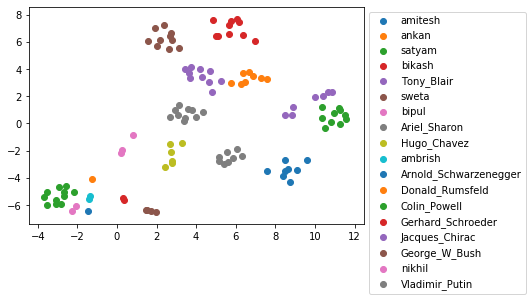

In [0]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

In [0]:
def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));

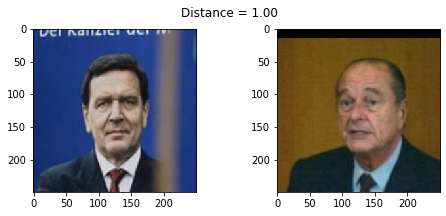

In [0]:
show_pair(0,23)

##Predict Faces

In [0]:
path = "/content/putin1.jpg"

Original Query Image


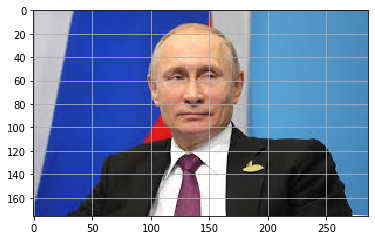

In [0]:
img = load_image(path)
print("Original Query Image")
plt.imshow(img)
plt.grid(b=None)

In [0]:
faces = alignment.getAllFaceBoundingBoxes(img)

In [0]:
faces

rectangles[[(96, 38) (171, 113)]]

In [0]:
img1 = img.copy()
font = cv2.FONT_HERSHEY_SIMPLEX

for bb in faces:
  face_aligned = alignment.align(96, img, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
  face_aligned = (face_aligned / 255.).astype(np.float32)
  embedding = model.predict(np.expand_dims(face_aligned, axis=0))[0]
  prediction = svc.predict([embedding])
  img1 = cv2.rectangle(img1, (bb.left(), bb.top()), (bb.left()+bb.width(), bb.top()+bb.height()), (255, 0, 0), 2)
  img2 = cv2.putText(img1, str(prediction[0]), (bb.left()+5,bb.top()-5), font, 0.8, (0,0,0), 1)
  print((prediction[0]))

Vladimir_Putin


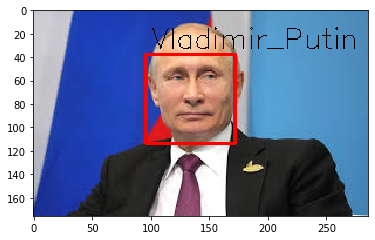

In [0]:
plt.imshow(img2)
plt.grid(b=False)

#2222

In [0]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

In [0]:
import cv2
import dlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from Align import AlignDlib
from tqdm import tqdm
from model import create_model
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from joblib import dump, load
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer

from keras.utils import np_utils 
from keras.datasets import mnist 
import seaborn as sns
import tensorflow
from keras.initializers import RandomNormal
from keras.initializers import he_normal
import matplotlib.pyplot as plt
import numpy as np
import time
import keras
from keras.models import Sequential 
from keras.layers import Dense, Activation 
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
import numpy as np
import os.path
import matplotlib.pyplot as plt

import warnings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [8, 4]
warnings.filterwarnings("ignore", category=FutureWarning)
%config InlineBackend.figure_format = 'retina'

In [0]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

In [0]:
def extensions(path):
    extension = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            ext = os.path.splitext(f)[1]
            extension.append(ext)
    return np.array(extension)

extension = extensions('photos')

In [0]:
(pd.Series(extension)).value_counts()

.jpg    113
.JPG     21
dtype: int64

In [0]:
def load_metadata(path):
  metadata = []
  for i in os.listdir(path):
    for f in os.listdir(os.path.join(path, i)):
      ext = os.path.splitext(f)[1]
      if ext == '.jpg' or ext == '.jpeg' or ext=='.JPG' or ext=='.png':
        metadata.append(IdentityMetadata(path, i, f))
  return np.array(metadata)

metadata = load_metadata('photos')

In [0]:
len(metadata)

134

In [0]:
metadata[0]

photos/samiul/DSC02858.JPG

In [0]:
names = np.array([m.name for m in metadata])

In [0]:
pd.Series(names).value_counts()#[:5]

satyam                   11
George_W_Bush            10
Jacques_Chirac           10
Gerhard_Schroeder        10
Colin_Powell             10
Ariel_Sharon             10
ambrish                   8
Donald_Rumsfeld           8
Arnold_Schwarzenegger     8
Vladimir_Putin            8
Tony_Blair                7
nikhil                    7
Hugo_Chavez               6
ankan                     5
sweta                     4
samiul                    4
bipul                     3
amitesh                   3
bikash                    2
dtype: int64

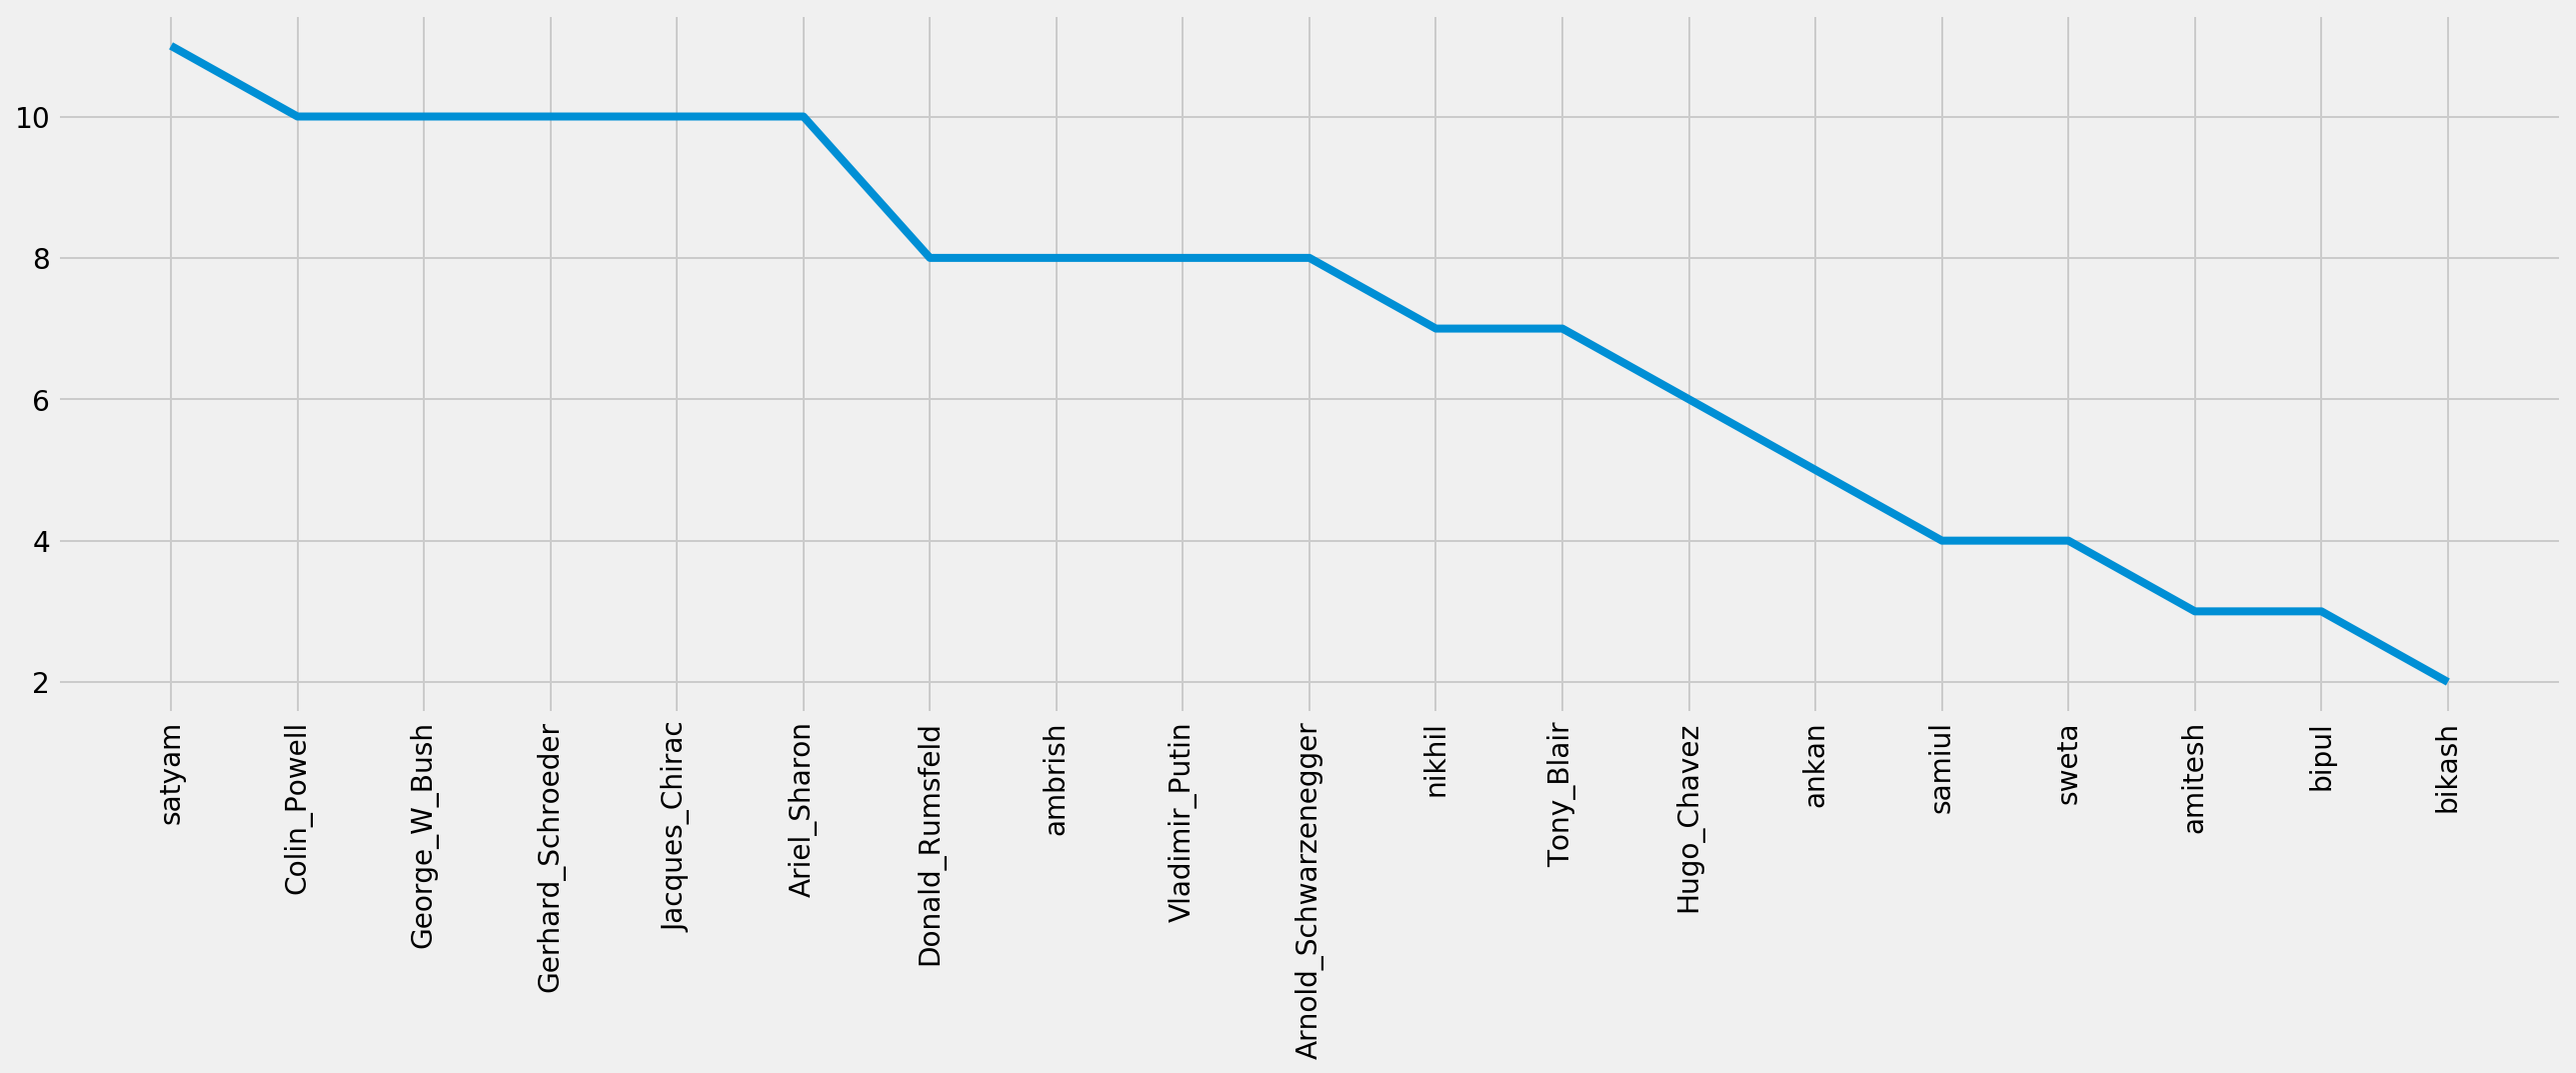

In [0]:
plt.figure(figsize=(20,6))
plt.plot(pd.Series(names).value_counts())
plt.xticks(rotation=90)
plt.grid(b=True)
plt.show()

In [0]:
alignment = AlignDlib('/content/drive/My Drive/face_recognition/models/landmarks.dat')

In [0]:
def load_image(path):
    img = cv2.imread(path, 1)
    return img[...,::-1]
  
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img),landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

In [0]:
#Load pretrained Model

model_of = create_model()
model_of.load_weights('/content/drive/My Drive/open_face.h5')

In [0]:
embedded = np.zeros((metadata.shape[0], 128))

for i, m in tqdm(enumerate(metadata)):
    try:
      img = load_image(m.image_path())
      img = align_image(img)
      # scale RGB values to interval [0,1]
      img = (img / 255.).astype(np.float32)
      # obtain embedding vector for image
      embedded[i] = model_of.predict(np.expand_dims(img, axis=0))[0]
    except:
      print(i,m)

134it [08:40,  3.88s/it]


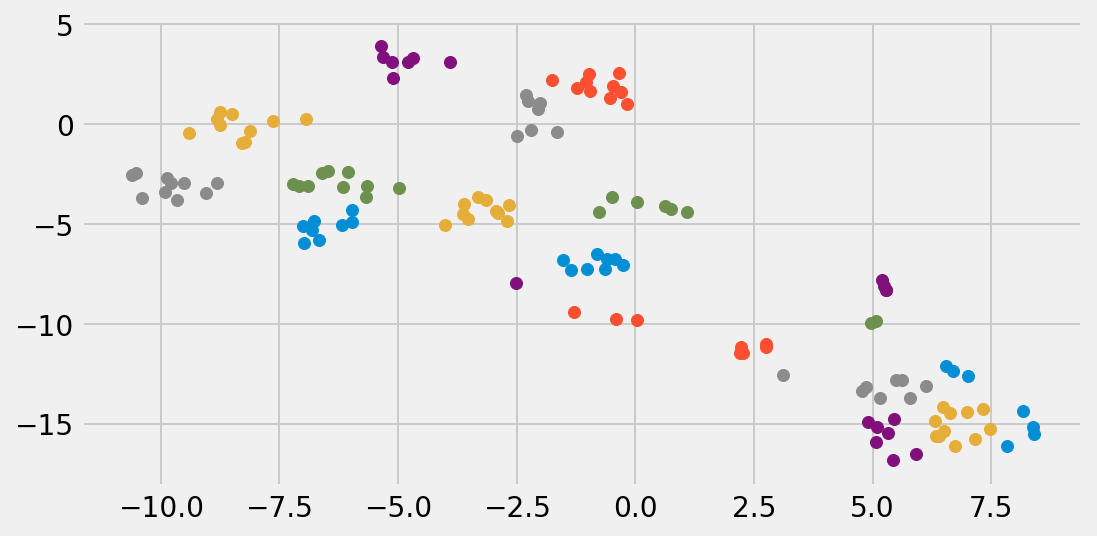

In [0]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(names)):
    idx = names == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)

In [0]:
print("Input data:",(embedded.shape))
print("Output class:",(names.shape))

Input data: (134, 128)
Output class: (134,)


In [0]:
df = pd.DataFrame(embedded)
df["output"] = names
#df.to_csv("embedded_.csv",index=False)

In [0]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,output
0,0.014240,0.133013,0.163010,0.027166,0.052657,0.059927,-0.051657,-0.130524,0.044192,-0.103644,0.027329,-0.030813,-0.060250,0.089897,0.060346,0.033671,0.075251,0.107026,-0.125287,0.004422,0.005994,0.109085,0.012151,0.075072,0.018594,-0.110335,-0.055919,0.156647,0.034124,0.002206,0.051950,0.060625,0.033584,0.108494,0.100496,0.099093,0.093118,0.012219,-0.008519,-0.079726,...,0.261824,0.181434,-0.112750,-0.002326,0.058019,0.133990,0.116997,-0.096291,0.071883,-0.013432,0.041885,0.002889,-0.025892,-0.079118,-0.023331,-0.009704,0.149571,0.043877,-0.151909,0.047080,-0.053880,-0.004754,0.058594,0.063240,0.106508,0.084171,-0.088436,0.021963,0.050819,0.058031,0.057435,0.088103,-0.001384,0.076988,0.020881,0.052175,0.051299,0.168273,-0.138402,samiul
1,-0.049816,0.200383,-0.007863,0.025025,0.055550,0.060105,0.053211,-0.213755,0.075220,0.003166,0.022641,-0.002125,0.014225,0.101542,0.007337,-0.030373,0.042214,0.055304,-0.086442,0.008507,-0.022729,-0.019806,-0.112997,0.054175,0.018540,-0.062682,-0.176794,0.084022,0.105019,0.138225,0.073546,0.180018,-0.012373,0.007918,0.081786,0.115373,0.025697,0.016929,0.000755,-0.089944,...,0.171230,0.125254,-0.107247,0.073618,0.063242,0.085418,0.030812,-0.047895,-0.023154,0.058395,0.040354,0.054560,0.003693,-0.064079,-0.032254,-0.146724,0.210044,0.022694,-0.075519,0.049695,0.027390,0.061741,0.011714,-0.057287,0.026023,0.035183,-0.043200,-0.074906,0.042744,0.090250,0.068461,0.051402,-0.070875,0.007659,0.031140,-0.038437,0.152713,0.032428,-0.152521,samiul
2,-0.023269,0.109737,0.050792,0.040646,0.041794,0.040835,-0.038897,-0.188386,0.072333,-0.019144,0.011133,-0.056367,-0.029177,0.097831,0.001437,0.032457,0.072572,0.212101,-0.063274,-0.007865,0.053395,0.017280,-0.004321,0.079713,0.016366,-0.094869,-0.126947,0.058034,0.043784,0.092459,0.064974,0.093098,0.037793,0.020446,0.170842,0.093589,0.010169,0.015436,-0.022556,-0.170318,...,0.213455,0.137961,-0.042590,0.016559,0.008958,0.158239,0.120866,-0.106665,0.098948,-0.025867,0.047071,0.129600,0.008859,-0.054341,-0.116138,-0.022732,0.127444,0.067379,-0.218404,0.088244,0.039456,0.011023,0.018649,0.046075,0.022075,0.074007,-0.040116,0.014994,0.019024,0.053117,0.016523,0.050856,-0.057207,0.055714,-0.023045,-0.030122,0.086357,0.127164,-0.133488,samiul
3,-0.049902,0.134443,0.164554,0.104548,0.125722,-0.005732,0.022614,-0.205176,0.085244,0.020588,-0.009994,0.001030,-0.052426,0.061523,0.091660,0.008599,0.069489,0.206272,-0.129360,-0.002472,-0.018320,0.015082,0.008723,0.064960,0.106660,-0.151453,-0.168724,0.127033,0.047496,0.056905,0.082428,0.183180,0.029209,0.069786,0.120039,0.011193,0.041584,0.008484,0.006027,-0.146885,...,0.180611,0.086076,-0.027520,0.056710,0.024270,0.061077,0.048341,-0.133575,0.036041,-0.001420,0.017598,0.093871,-0.056557,-0.018833,-0.017714,0.051478,0.093220,0.087765,-0.120440,0.142338,0.030184,-0.028533,0.045261,0.030048,0.084745,0.039364,-0.129997,-0.032405,0.120767,0.029500,0.066426,0.076445,0.025525,-0.052095,-0.013209,0.021208,0.080453,0.081293,-0.132601,samiul
4,0.035966,0.131935,-0.059532,-0.130664,-0.003347,-0.056471,0.019027,-0.183440,-0.118823,0.069055,0.026678,-0.056534,0.002959,0.112872,0.079517,0.062036,-0.009740,-0.040522,0.152075,-0.061935,-0.081882,0.197105,-0.058348,-0.112408,-0.058143,0.170052,0.071998,0.018735,0.163326,0.184416,-0.185867,0.040042,0.046947,-0.062335,0.124207,-0.001533,0.130487,0.020860,0.199807,0.020338,...,0.137625,0.079759,0.011530,-0.053414,0.108708,-0.008917,0.014506,0.014522,0.046488,0.204002,-0.021948,0.029990,0.059853,0.013397,-0.040417,-0.114282,0.020494,0.039996,0.036891,0.015231,0.018880,0.150778,-0.094683,-0.022475,-0.043009,-0.024391,0.054603,-0.041934,-0.035137,-0.056900,-0.066215,0.054030,-0.081874,0.089238,-0.007503,-0.037187,0.065456,0.0178

In [0]:
from sklearn.preprocessing import LabelEncoder as le

names_encode = LabelEncoder().fit(names)
Y = names_encode.transform(names)

In [0]:
names

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [0]:
le.fit(names)

LabelEncoder()

In [0]:
Y = le.transform(names)

In [0]:
le.inverse_transform(Y)

In [0]:
len(set(names))

19

In [0]:
y = np.zeros((embedded.shape[0],len(set(Y))),dtype=int)
y.shape

(134, 19)

In [0]:
for i,name in enumerate(names):
  ind = Y[i]
  y[i][ind]=1

In [0]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [0]:
train_idx = np.arange(embedded.shape[0]) % 5 != 0
test_idx = np.arange(embedded.shape[0]) % 5 == 0

print(np.sum(train_idx))
print(np.sum(test_idx))

107
27


In [0]:
X_train = embedded[train_idx]
y_train = y[train_idx]

X_val = embedded[test_idx]
y_val = y[test_idx]

In [0]:
print(X_train.shape)
print(y_train.shape)

(107, 128)
(107, 19)


In [0]:
output_dim = y_train.shape[1]
input_dim = X_train.shape[1]

batch_size = 8
nb_epoch = 50

In [0]:
model_clf= Sequential()

model_clf.add(Dense(250, activation='relu', input_shape=(input_dim,), kernel_initializer=keras.initializers.he_normal(seed=None)))
model_clf.add(BatchNormalization())
#model_clf.add(Dropout(0.5))

model_clf.add(Dense(100, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=None)) )
model_clf.add(BatchNormalization())
#model_clf.add(Dropout(0.5))

model_clf.add(Dense(100, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=None)) )
model_clf.add(BatchNormalization())
#model_clf.add(Dropout(0.5))

model_clf.add(Dense(50, activation='relu', kernel_initializer=keras.initializers.he_normal(seed=None)) )
model_clf.add(BatchNormalization())
model_clf.add(Dropout(0.5))

model_clf.add(Dense(output_dim,activation='softmax'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model_clf.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 250)               32250     
_________________________________________________________________
batch_normalization_1 (Batch (None, 250)               1000      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 50)               

In [0]:
model_clf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
history = model_clf.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch,validation_data=[X_val,y_val])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 107 samples, validate on 27 samples
Epoch 1/50
107/107 [==============================] - 2s 23ms/step - loss: 3.7244 - acc: 0.0654 - val_loss: 2.9004 - val_acc: 0.1481
Epoch 2/50
107/107 [==============================] - 0s 557us/step - loss: 3.0818 - acc: 0.1402 - val_loss: 2.2945 - val_acc: 0.4815
Epoch 3/50
107/107 [==============================] - 0s 540us/step - loss: 2.5240 - acc: 0.2897 - val_loss: 1.8107 - val_acc: 0.5185
Epoch 4/50
107/107 [==============================] - 0s 498us/step - loss: 2.1137 - acc: 0.4019 - val_loss: 1.4778 - val_acc: 0.6667
Epoch 5/50
107/107 [==============================] - 0s 532us/step - loss: 1.9456 - acc: 0.3738 - val_loss: 1.2901 - val_acc: 0.6296
Epoch 6/50
107/107 [==============================] - 0s 523us/step - loss: 1.8963 - acc: 0.4019 - val_loss: 1.1901 - val_acc: 0.6667
Epoch 7/50
107/107 [==============================] - 0s

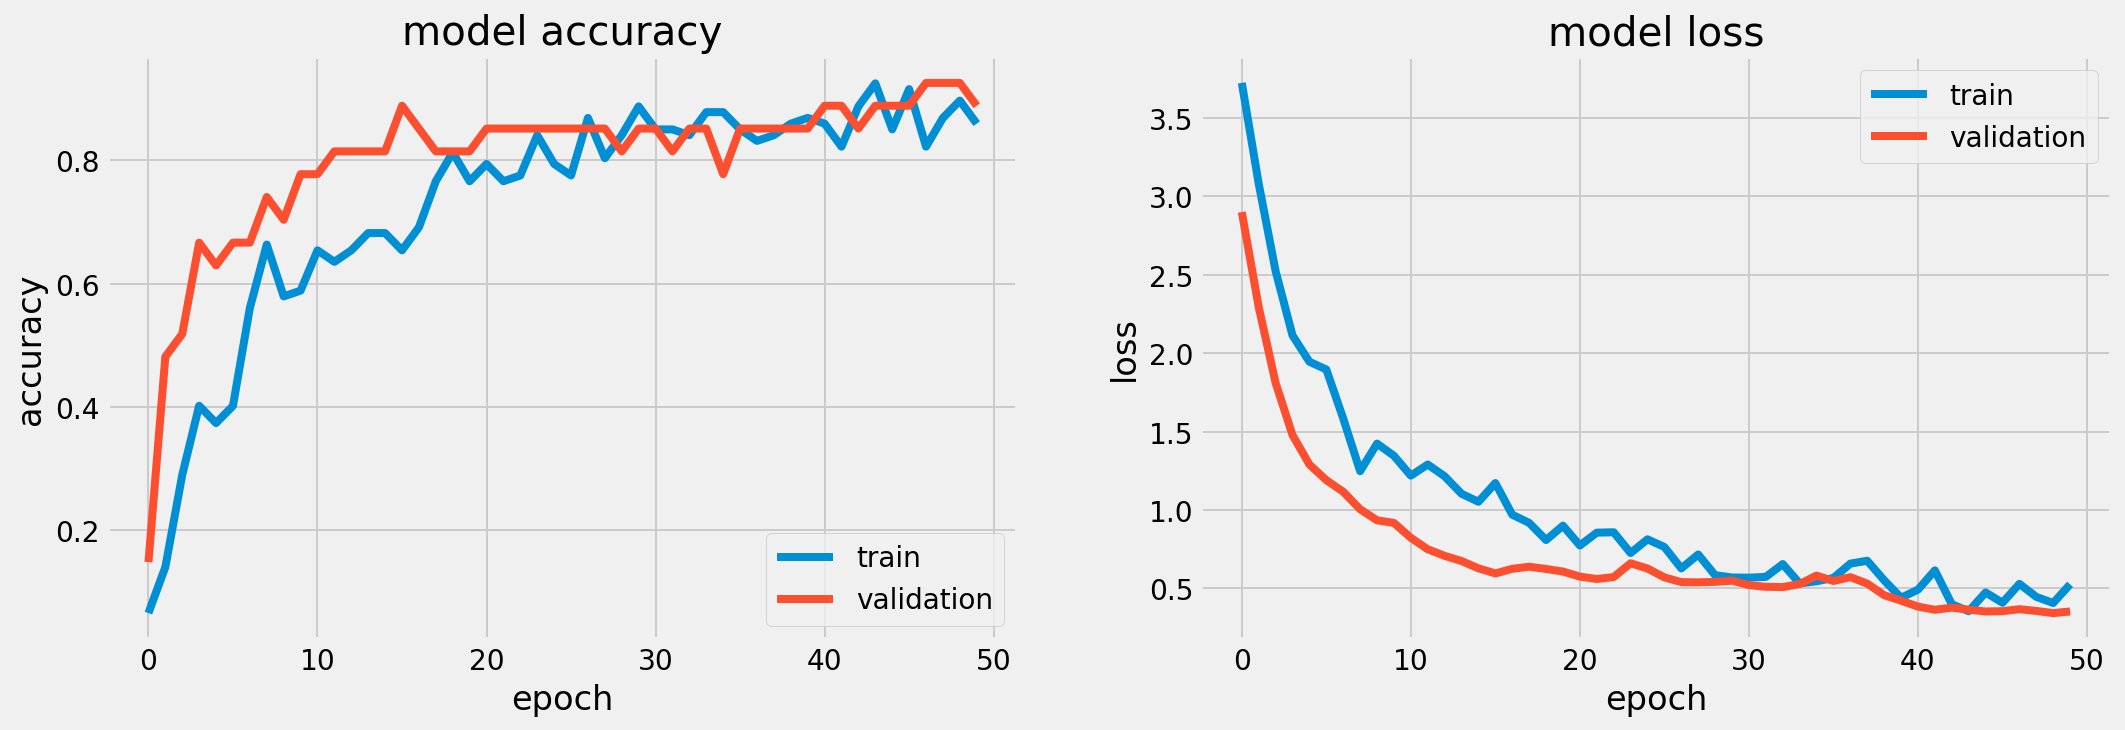

In [0]:
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.show()

###Predict Faces

In [0]:
path = "/content/G.Bush.jpg"

Original Query Image


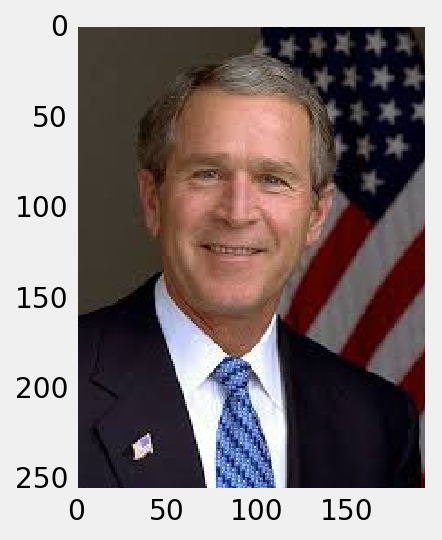

In [0]:
img = load_image(path)
print("Original Query Image")
plt.imshow(img)
plt.grid(b=None)

In [0]:
faces = alignment.getAllFaceBoundingBoxes(img)
faces

rectangles[[(46, 56) (135, 146)]]

In [0]:
for i in range(len(faces)):
  face_aligned = alignment.align(96, img, faces[i], landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
  face_aligned = (face_aligned / 255.).astype(np.float32)
  embedding = model_of.predict(np.expand_dims(face_aligned, axis=0))[0]
  pred = model_clf.predict([[embedding]])
  ind = np.argsort(pred[0])
  print(ind[::-1][:5])
  print("Prediction: ",le.inverse_transform([ind[::-1][0]])[0])
  print("Prediction Probability: ",pred[0][ind[::-1][0]]*100,"%")
  print()

[ 4  5  0  1 18]
Prediction:  George_W_Bush
Prediction Probability:  99.1236925125122 %

